# 流变性能预测 - 基于物理信息神经网络（PINN）的实现

本笔记本使用物理信息神经网络（Physics-Informed Neural Networks, PINN）来预测高分子材料的流变性能。相比传统的机器学习方法，PINN具有以下优势：

1. 结合物理约束：
   - Cox-Merz规则
   - Kramers-Kronig关系
   - 储能损耗角物理约束
   - 热力学约束

2. 改进的特征工程：
   - WLF（Williams-Landel-Ferry）时温等效性
   - 考虑分子量和温度的耦合效应
   - 长宽比的非线性效应

3. 不确定性量化：
   - 使用深度集成和Monte Carlo Dropout
   - 提供预测的置信区间

In [44]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from typing import Tuple, List

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子以确保可重复性
RANDOM_SEED = 24
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    
# 设置全局参数
BATCH_SIZE = 64        # 增大批次大小
LEARNING_RATE = 5e-4   # 调整学习率
EPOCHS = 1000          # 增加训练轮数
PHYSICS_WEIGHT = 0.01  # 降低物理约束权重
MC_SAMPLES = 50        # Monte Carlo采样次数

使用设备: cpu


In [45]:
# 数据加载和预处理
class RheologyDataset:
    def __init__(self, csv_path: str):
        """初始化数据集类
        
        Args:
            csv_path: PB_Data.csv的路径
        """
        # 读取数据
        self.df = pd.read_csv(csv_path)
        self.process_data()
        
    def process_data(self):
        """数据预处理和特征工程"""
        df = self.df
        
        # 基本特征工程
        df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
        df['log_freq'] = np.log10(df['Freq_rad_s'])
        
        # WLF时温等效性特征
        T_ref = 25  # 参考温度
        C1 = 8.86   # WLF参数
        C2 = 101.6  # WLF参数
        df['aT'] = 10 ** (-C1 * (df['Temp_C'] - T_ref) / (C2 + df['Temp_C'] - T_ref))
        df['reduced_freq'] = df['Freq_rad_s'] * df['aT']
        
        # 温度相关特征
        df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)  # 开尔文温度的倒数
        df['T_x_aspect'] = df['Temp_C'] * df['aspect_ratio']
        
        # 对数转换目标变量（使用安全的对数转换）
        df['log_G1'] = np.log10(np.clip(df['G1_Pa'], 1e-10, None))
        df['log_G2'] = np.log10(np.clip(df['G2_Pa'], 1e-10, None))
        
        print("\n数据统计:")
        print("\nG1_Pa范围:", df['G1_Pa'].min(), "-", df['G1_Pa'].max())
        print("G2_Pa范围:", df['G2_Pa'].min(), "-", df['G2_Pa'].max())
        print("\nlog_G1范围:", df['log_G1'].min(), "-", df['log_G1'].max())
        print("log_G2范围:", df['log_G2'].min(), "-", df['log_G2'].max())
        
        # 定义特征列
        self.feature_cols = [
            'Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 
            'log_freq', 'temp_inv', 'T_x_aspect', 'aT'
        ]
        self.target_cols = ['log_G1', 'log_G2']
        
        # 数据标准化
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        # 准备训练数据
        X = self.scaler_X.fit_transform(df[self.feature_cols])
        y = self.scaler_y.fit_transform(df[self.target_cols])
        
        # 打印标准化参数
        print("\n特征标准化参数:")
        for name, scale, mean in zip(self.feature_cols, self.scaler_X.scale_, self.scaler_X.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
            
        print("\n目标标准化参数:")
        for name, scale, mean in zip(self.target_cols, self.scaler_y.scale_, self.scaler_y.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
        
        # 分割数据集
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=None
        )
        
        # 转换为PyTorch张量
        self.X_train = torch.FloatTensor(X_train).to(device)
        self.y_train = torch.FloatTensor(y_train).to(device)
        self.X_val = torch.FloatTensor(X_val).to(device)
        self.y_val = torch.FloatTensor(y_val).to(device)
        
        # 创建数据加载器
        train_dataset = TensorDataset(self.X_train, self.y_train)
        val_dataset = TensorDataset(self.X_val, self.y_val)
        
        self.train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False
        )
        
    def inverse_transform_y(self, y_scaled):
        """将标准化的预测值转换回原始尺度"""
        if isinstance(y_scaled, torch.Tensor):
            y_scaled = y_scaled.cpu().detach().numpy()
        
        # 首先反标准化到对数空间
        y_log = self.scaler_y.inverse_transform(y_scaled)
        
        # 然后从对数空间转换到原始空间
        return np.power(10.0, y_log)

# 加载数据
dataset = RheologyDataset("PB_Data.csv")
print("\n数据集信息:")
print(f"训练集大小: {len(dataset.X_train)}")
print(f"验证集大小: {len(dataset.X_val)}")
print(f"\n特征列: {dataset.feature_cols}")
print(f"目标列: {dataset.target_cols}")


数据统计:

G1_Pa范围: 7.14e-07 - 785.8
G2_Pa范围: 7.59e-06 - 186.69

log_G1范围: -6.146301788223826 - 2.8953120244757873
log_G2范围: -5.11975822410452 - 2.271121055704133

特征标准化参数:
Length_nm: scale=97.3858, mean=111.0000
Width_nm: scale=4.6933, mean=25.4513
aspect_ratio: scale=4.7682, mean=4.8483
Temp_C: scale=7.0711, mean=25.0000
log_freq: scale=1.2018, mean=-0.0001
temp_inv: scale=0.0001, mean=0.0034
T_x_aspect: scale=128.5372, mean=121.2069
aT: scale=3.4040, mean=2.7386

目标标准化参数:
log_G1: scale=2.0969, mean=0.5570
log_G2: scale=1.2305, mean=0.8273

数据集信息:
训练集大小: 1500
验证集大小: 375

特征列: ['Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 'log_freq', 'temp_inv', 'T_x_aspect', 'aT']
目标列: ['log_G1', 'log_G2']


In [46]:
class RheologyPINN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256, dropout_rate: float = 0.1):
        """初始化PINN模型
        
        Args:
            input_dim: 输入特征维度
            hidden_dim: 隐藏层维度
            dropout_rate: Dropout比率，用于不确定性估计
        """
        super(RheologyPINN, self).__init__()
        
        # 共享编码器网络（更深层次）
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # G'预测分支（专门的结构）
        self.g_prime_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
        # G"预测分支
        self.g_double_prime_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 通过编码器
        encoded = self.encoder(x)
        
        # 预测G'和G"
        g_prime = self.g_prime_branch(encoded)
        g_double_prime = self.g_double_prime_branch(encoded)
        
        return torch.cat([g_prime, g_double_prime], dim=1)
    
    def predict_with_uncertainty(self, x: torch.Tensor, mc_samples: int = 100) -> Tuple[torch.Tensor, torch.Tensor]:
        """使用Monte Carlo Dropout进行带不确定性的预测"""
        self.train()  # 启用dropout
        predictions = []
        
        with torch.no_grad():
            for _ in range(mc_samples):
                pred = self(x)
                predictions.append(pred)
                
        predictions = torch.stack(predictions)
        mean_pred = predictions.mean(dim=0)
        std_pred = predictions.std(dim=0)
        
        return mean_pred, std_pred
    
    def physics_loss(self, x_batch: torch.Tensor, y_pred: torch.Tensor, dataset: RheologyDataset) -> torch.Tensor:
        """计算物理约束损失"""
        # 获取频率相关参数（避免numpy转换）
        freq_idx = dataset.feature_cols.index('log_freq')
        log_freq = x_batch[:, freq_idx] * torch.tensor(dataset.scaler_X.scale_[freq_idx]).to(device) + \
                  torch.tensor(dataset.scaler_X.mean_[freq_idx]).to(device)
        freq = torch.pow(10.0, log_freq)
        
        # 反标准化预测值（保持在对数空间）
        y_std = torch.tensor(dataset.scaler_y.scale_).to(device)
        y_mean = torch.tensor(dataset.scaler_y.mean_).to(device)
        log_g_prime = y_pred[:, 0] * y_std[0] + y_mean[0]
        log_g_double_prime = y_pred[:, 1] * y_std[1] + y_mean[1]
        
        # 转换到线性空间
        g_prime = torch.pow(10.0, log_g_prime)
        g_double_prime = torch.pow(10.0, log_g_double_prime)
        
        # 1. Cox-Merz规则约束
        log_complex_viscosity = torch.log10(torch.sqrt(g_prime**2 + g_double_prime**2) / freq + 1e-10)
        visc_diff = log_complex_viscosity[1:] - log_complex_viscosity[:-1]
        cox_merz_loss = torch.mean(torch.relu(-visc_diff))
        
        # 2. 储能损耗角物理约束 (0 < δ < π/2)
        loss_tangent = g_double_prime / (g_prime + 1e-10)
        angle_loss = torch.mean(torch.relu(-loss_tangent) + 
                              torch.relu(loss_tangent - torch.tensor(np.pi/2).to(device)))
        
        # 3. 热力学约束：G' > 0 和 G" > 0（在对数空间中）
        thermo_loss = torch.mean(torch.relu(-log_g_prime) + torch.relu(-log_g_double_prime))
        
        # 组合所有物理损失，使用较小的权重
        total_physics_loss = (0.1 * cox_merz_loss + 
                            0.1 * angle_loss + 
                            0.2 * thermo_loss)
        
        return total_physics_loss

# 初始化模型
model = RheologyPINN(input_dim=len(dataset.feature_cols)).to(device)
print("\nPINN模型结构:")
print(model)


PINN模型结构:
RheologyPINN(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (g_prime_branch): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, 


开始训练...
Epoch [10/1000]
Train - Total: 0.5686, G': 0.5816, G": 0.4950, Physics: 2.1636
Val   - Total: 0.4606, G': 0.5049, G": 0.3704
LR: 0.000021
Epoch [20/1000]
Train - Total: 0.4295, G': 0.4402, G": 0.3700, Physics: 1.7366
Val   - Total: 0.3243, G': 0.3618, G": 0.2451
LR: 0.000025
Epoch [30/1000]
Train - Total: 0.3770, G': 0.3888, G": 0.3290, Physics: 1.2111
Val   - Total: 0.2867, G': 0.3274, G": 0.1978
LR: 0.000032
Epoch [40/1000]
Train - Total: 0.3281, G': 0.3411, G": 0.2785, Physics: 1.2042
Val   - Total: 0.2678, G': 0.3029, G": 0.1872
LR: 0.000041
Epoch [50/1000]
Train - Total: 0.3130, G': 0.3278, G": 0.2671, Physics: 0.9543
Val   - Total: 0.2520, G': 0.2903, G": 0.1722
LR: 0.000052
Epoch [60/1000]
Train - Total: 0.2924, G': 0.3086, G": 0.2415, Physics: 1.0771
Val   - Total: 0.2252, G': 0.2590, G": 0.1532
LR: 0.000066
Epoch [70/1000]
Train - Total: 0.2407, G': 0.2484, G": 0.2013, Physics: 1.1277
Val   - Total: 0.2036, G': 0.2425, G": 0.1232
LR: 0.000082
Epoch [80/1000]
Train - T

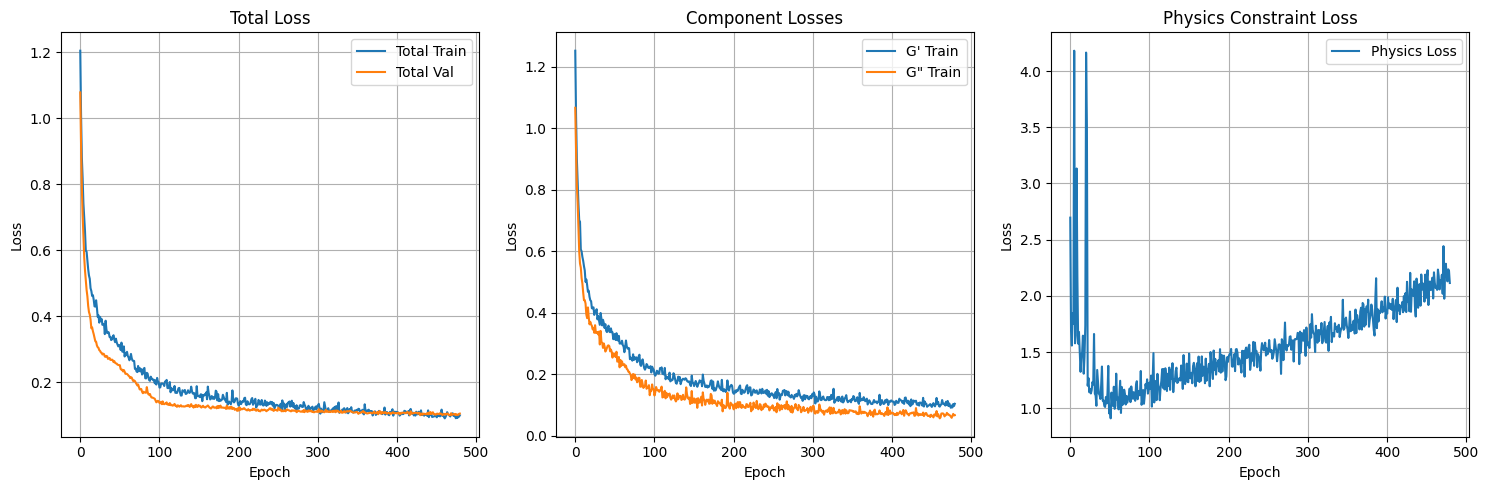

In [47]:
# 定义训练函数
def train_model(model: RheologyPINN, 
                dataset: RheologyDataset,
                epochs: int,
                physics_weight: float) -> Tuple[List[float], List[float]]:
    """训练PINN模型
    
    Args:
        model: PINN模型
        dataset: 数据集对象
        epochs: 训练轮数
        physics_weight: 物理约束损失权重
        
    Returns:
        train_losses: 训练损失历史
        val_losses: 验证损失历史
    """
    # 优化器设置
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                            epochs=epochs,
                                            steps_per_epoch=len(dataset.train_loader))
    
    # 损失函数
    mse_loss = nn.MSELoss()
    
    # 记录训练过程
    train_losses = []
    val_losses = []
    g_prime_losses = []
    g_double_prime_losses = []
    physics_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 50
    
    print("\n开始训练...")
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_losses = []
        epoch_g_prime_losses = []
        epoch_g_double_prime_losses = []
        epoch_physics_losses = []
        
        for batch_X, batch_y in dataset.train_loader:
            optimizer.zero_grad()
            
            # 前向传播
            y_pred = model(batch_X)
            
            # 分别计算G'和G"的损失
            g_prime_loss = mse_loss(y_pred[:, 0], batch_y[:, 0])
            g_double_prime_loss = mse_loss(y_pred[:, 1], batch_y[:, 1])
            
            # 数据损失（加权组合）
            data_loss = 0.6 * g_prime_loss + 0.4 * g_double_prime_loss
            
            # 物理约束损失
            physics_loss = model.physics_loss(batch_X, y_pred, dataset)
            
            # 动态权重计算
            current_step = epoch * len(dataset.train_loader) + len(epoch_losses)
            total_steps = epochs * len(dataset.train_loader)
            # 使用余弦退火调整物理约束权重
            physics_weight_dynamic = physics_weight * (
                1 + np.cos(np.pi * current_step / total_steps)
            ) / 2
            
            # 总损失
            total_loss = data_loss + physics_weight_dynamic * physics_loss
            
            # 反向传播
            total_loss.backward()
            
            # 梯度裁剪（按范数）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # 记录损失
            epoch_losses.append(total_loss.item())
            epoch_g_prime_losses.append(g_prime_loss.item())
            epoch_g_double_prime_losses.append(g_double_prime_loss.item())
            epoch_physics_losses.append(physics_loss.item())
        
        # 计算平均损失
        avg_train_loss = np.mean(epoch_losses)
        avg_g_prime_loss = np.mean(epoch_g_prime_losses)
        avg_g_double_prime_loss = np.mean(epoch_g_double_prime_losses)
        avg_physics_loss = np.mean(epoch_physics_losses)
        
        train_losses.append(avg_train_loss)
        g_prime_losses.append(avg_g_prime_loss)
        g_double_prime_losses.append(avg_g_double_prime_loss)
        physics_losses.append(avg_physics_loss)
        
        # 验证阶段
        model.eval()
        val_epoch_losses = []
        val_g_prime_losses = []
        val_g_double_prime_losses = []
        
        with torch.no_grad():
            for batch_X, batch_y in dataset.val_loader:
                y_pred = model(batch_X)
                
                # 分别计算验证损失
                val_g_prime_loss = mse_loss(y_pred[:, 0], batch_y[:, 0])
                val_g_double_prime_loss = mse_loss(y_pred[:, 1], batch_y[:, 1])
                val_data_loss = 0.6 * val_g_prime_loss + 0.4 * val_g_double_prime_loss
                val_physics_loss = model.physics_loss(batch_X, y_pred, dataset)
                
                val_total_loss = val_data_loss + physics_weight_dynamic * val_physics_loss
                val_epoch_losses.append(val_total_loss.item())
                val_g_prime_losses.append(val_g_prime_loss.item())
                val_g_double_prime_losses.append(val_g_double_prime_loss.item())
        
        avg_val_loss = np.mean(val_epoch_losses)
        avg_val_g_prime_loss = np.mean(val_g_prime_losses)
        avg_val_g_double_prime_loss = np.mean(val_g_double_prime_losses)
        val_losses.append(avg_val_loss)
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # 提前停止检查
        if patience_counter >= max_patience:
            print(f'\n提前停止! 验证损失在{max_patience}轮内没有改善.')
            break
        
        # 打印训练进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train - Total: {avg_train_loss:.4f}, G\': {avg_g_prime_loss:.4f}, '
                  f'G": {avg_g_double_prime_loss:.4f}, Physics: {avg_physics_loss:.4f}')
            print(f'Val   - Total: {avg_val_loss:.4f}, G\': {avg_val_g_prime_loss:.4f}, '
                  f'G": {avg_val_g_double_prime_loss:.4f}')
            print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # 加载最佳模型
    model.load_state_dict(best_model_state)
    
    # 绘制详细的训练历史
    plt.figure(figsize=(15, 5))
    
    # 损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Total Train')
    plt.plot(val_losses, label='Total Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss')
    plt.legend()
    plt.grid(True)
    
    # G'和G"损失曲线
    plt.subplot(1, 3, 2)
    plt.plot(g_prime_losses, label='G\' Train')
    plt.plot(g_double_prime_losses, label='G" Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Component Losses')
    plt.legend()
    plt.grid(True)
    
    # 物理约束损失曲线
    plt.subplot(1, 3, 3)
    plt.plot(physics_losses, label='Physics Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Physics Constraint Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses

# 训练模型
train_losses, val_losses = train_model(model, dataset, EPOCHS, PHYSICS_WEIGHT)


R² 分数:
G' (储能模量): 0.9432
G" (损耗模量): 0.9238


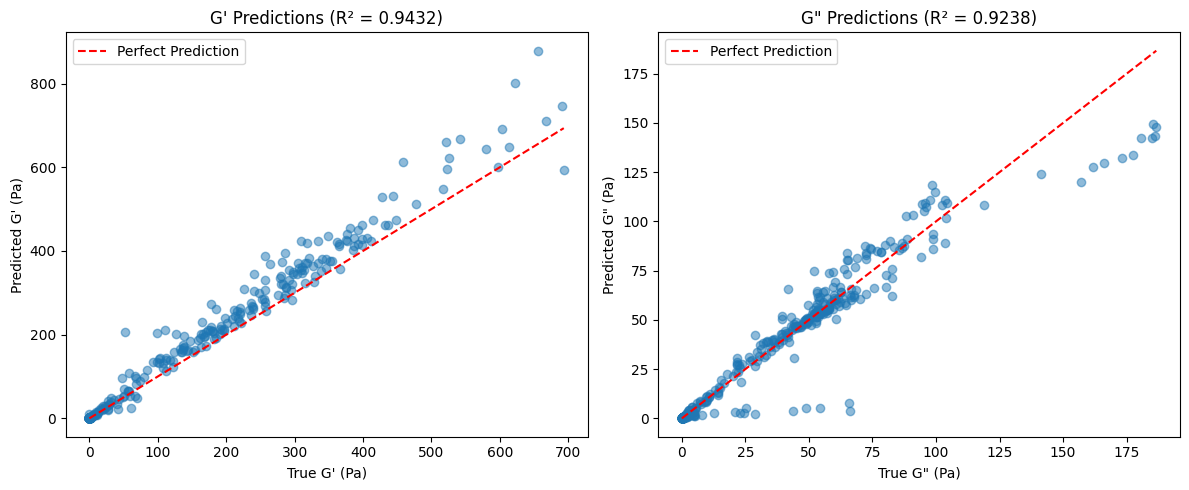

In [48]:
# 模型评估函数
def evaluate_model(model: RheologyPINN, dataset: RheologyDataset):
    """评估模型性能
    
    Args:
        model: 训练好的PINN模型
        dataset: 数据集对象
    """
    model.eval()
    with torch.no_grad():
        # 在验证集上进行预测
        y_pred = model(dataset.X_val)
        y_true = dataset.y_val
        
        # 转换回原始尺度
        y_pred_orig = dataset.inverse_transform_y(y_pred)
        y_true_orig = dataset.inverse_transform_y(y_true)
        
        # 计算R²分数
        from sklearn.metrics import r2_score
        r2_g1 = r2_score(y_true_orig[:, 0], y_pred_orig[:, 0])
        r2_g2 = r2_score(y_true_orig[:, 1], y_pred_orig[:, 1])
        
        print(f"\nR² 分数:")
        print(f"G' (储能模量): {r2_g1:.4f}")
        print(f"G\" (损耗模量): {r2_g2:.4f}")
        
        # 绘制预测vs实际值的散点图
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_orig[:, 0], y_pred_orig[:, 0], alpha=0.5)
        plt.plot([y_true_orig[:, 0].min(), y_true_orig[:, 0].max()],
                 [y_true_orig[:, 0].min(), y_true_orig[:, 0].max()],
                 'r--', label='Perfect Prediction')
        plt.xlabel('True G\' (Pa)')
        plt.ylabel('Predicted G\' (Pa)')
        plt.title(f'G\' Predictions (R² = {r2_g1:.4f})')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(y_true_orig[:, 1], y_pred_orig[:, 1], alpha=0.5)
        plt.plot([y_true_orig[:, 1].min(), y_true_orig[:, 1].max()],
                 [y_true_orig[:, 1].min(), y_true_orig[:, 1].max()],
                 'r--', label='Perfect Prediction')
        plt.xlabel('True G" (Pa)')
        plt.ylabel('Predicted G" (Pa)')
        plt.title(f'G" Predictions (R² = {r2_g2:.4f})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# 评估模型
evaluate_model(model, dataset)

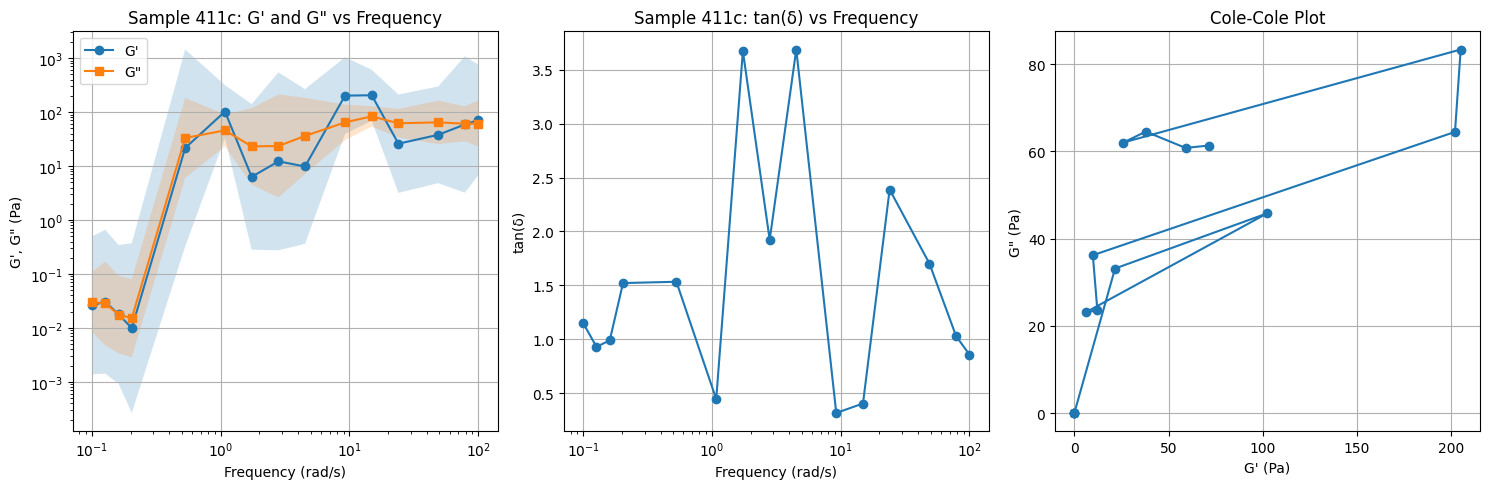


新样本预测结果:
   Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s  G1_Pa_pred  G2_Pa_pred  \
0       411c        300     20.94      25       0.100    0.026305    0.030305   
1       411c        300     20.94      25       0.127    0.030625    0.028530   
2       411c        300     20.94      25       0.161    0.017886    0.017734   
3       411c        300     20.94      25       0.204    0.009945    0.015139   
4       411c        300     20.94      25       0.530   21.590466   33.129375   
5       411c        300     20.94      25       1.080  102.342949   45.786758   
6       411c        300     20.94      25       1.740    6.304036   23.143364   
7       411c        300     20.94      25       2.810   12.224317   23.504292   
8       411c        300     20.94      25       4.520    9.815197   36.175236   
9       411c        300     20.94      25       9.240  201.913254   64.451225   
10      411c        300     20.94      25      14.900  204.935135   83.339180   
11      411c      

In [49]:
# 预测新样本的函数
def predict_rheology(model: RheologyPINN, 
                    sample_data: pd.DataFrame, 
                    dataset: RheologyDataset,
                    with_uncertainty: bool = True) -> pd.DataFrame:
    """预测新样本的流变性能
    
    Args:
        model: 训练好的PINN模型
        sample_data: 包含新样本数据的DataFrame
        dataset: 数据集对象
        with_uncertainty: 是否计算预测不确定性
        
    Returns:
        预测结果DataFrame
    """
    # 特征工程
    processed_data = sample_data.copy()
    processed_data['aspect_ratio'] = processed_data['Length_nm'] / processed_data['Width_nm']
    processed_data['log_freq'] = np.log10(processed_data['Freq_rad_s'])
    
    # WLF时温等效性
    T_ref = 25
    C1 = 8.86
    C2 = 101.6
    processed_data['aT'] = 10 ** (-C1 * (processed_data['Temp_C'] - T_ref) / 
                                 (C2 + processed_data['Temp_C'] - T_ref))
    
    # 其他特征
    processed_data['temp_inv'] = 1 / (processed_data['Temp_C'] + 273.15)
    processed_data['T_x_aspect'] = processed_data['Temp_C'] * processed_data['aspect_ratio']
    
    # 准备输入特征
    X_new = dataset.scaler_X.transform(processed_data[dataset.feature_cols])
    X_new = torch.FloatTensor(X_new).to(device)
    
    # 预测
    model.eval()
    if with_uncertainty:
        # 使用Monte Carlo Dropout进行带不确定性的预测
        mean_pred, std_pred = model.predict_with_uncertainty(X_new, MC_SAMPLES)
        y_pred = mean_pred
        
        # 转换预测值和不确定性范围
        y_pred_orig = dataset.inverse_transform_y(y_pred)
        y_upper = dataset.inverse_transform_y(y_pred + 2 * std_pred)  # 95% 置信区间
        y_lower = dataset.inverse_transform_y(y_pred - 2 * std_pred)
        
        # 添加预测结果和不确定性
        results = processed_data.copy()
        results['G1_Pa_pred'] = y_pred_orig[:, 0]
        results['G2_Pa_pred'] = y_pred_orig[:, 1]
        results['G1_Pa_lower'] = y_lower[:, 0]
        results['G1_Pa_upper'] = y_upper[:, 0]
        results['G2_Pa_lower'] = y_lower[:, 1]
        results['G2_Pa_upper'] = y_upper[:, 1]
    else:
        # 不计算不确定性的简单预测
        with torch.no_grad():
            y_pred = model(X_new)
            y_pred_orig = dataset.inverse_transform_y(y_pred)
            
            results = processed_data.copy()
            results['G1_Pa_pred'] = y_pred_orig[:, 0]
            results['G2_Pa_pred'] = y_pred_orig[:, 1]
    
    results['tan_delta_pred'] = results['G2_Pa_pred'] / results['G1_Pa_pred']
    return results

# 示例：预测新样本
new_samples = pd.DataFrame({
    "Sample_ID": ["411c"] * 15,
    "Length_nm": [300] * 15,
    "Width_nm": [20.94] * 15,
    "Temp_C": [25] * 15,
    "Freq_rad_s": [0.1, 0.127, 0.161, 0.204, 0.53, 1.08, 1.74, 2.81, 
                   4.52, 9.24, 14.9, 24, 48.9, 78.8, 100]
})

predictions = predict_rheology(model, new_samples, dataset)

# 可视化预测结果
def plot_predictions(predictions: pd.DataFrame, sample_id: str):
    """可视化预测结果
    
    Args:
        predictions: 预测结果DataFrame
        sample_id: 样品ID
    """
    sample_data = predictions[predictions['Sample_ID'] == sample_id]
    
    plt.figure(figsize=(15, 5))
    
    # G' 和 G" 随频率的变化
    plt.subplot(1, 3, 1)
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G1_Pa_pred'], 'o-', label="G'")
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G2_Pa_pred'], 's-', label='G"')
    if 'G1_Pa_lower' in sample_data.columns:
        plt.fill_between(sample_data['Freq_rad_s'], 
                        sample_data['G1_Pa_lower'],
                        sample_data['G1_Pa_upper'],
                        alpha=0.2)
        plt.fill_between(sample_data['Freq_rad_s'],
                        sample_data['G2_Pa_lower'],
                        sample_data['G2_Pa_upper'],
                        alpha=0.2)
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('G\', G" (Pa)')
    plt.title(f'Sample {sample_id}: G\' and G" vs Frequency')
    plt.legend()
    plt.grid(True)
    
    # tan(δ) 随频率的变化
    plt.subplot(1, 3, 2)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['tan_delta_pred'], 'o-')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('tan(δ)')
    plt.title(f'Sample {sample_id}: tan(δ) vs Frequency')
    plt.grid(True)
    
    # Cole-Cole图
    plt.subplot(1, 3, 3)
    plt.plot(sample_data['G1_Pa_pred'], sample_data['G2_Pa_pred'], 'o-')
    plt.xlabel('G\' (Pa)')
    plt.ylabel('G" (Pa)')
    plt.title('Cole-Cole Plot')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 为每个新样本绘制预测结果
for sample_id in predictions['Sample_ID'].unique():
    plot_predictions(predictions, sample_id)

# 打印预测结果
print("\n新样本预测结果:")
print(predictions[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 
                  'Freq_rad_s', 'G1_Pa_pred', 'G2_Pa_pred', 'tan_delta_pred']])